
# Markovian Adapted OT Experiment Using Matrix Representations

**Overview:**  
This notebook examines the adapted Wasserstein distance for two Markov processes (T = 10) generated via matrix representations.
 
**Process Definitions:**

- **Process X:**  
  - \(x_1\sim \mathcal{N}(0,1)\)  
  - \(x_t\sim \mathcal{N}(x_{t-1},1)\) for \(t\ge2\)

  Generated using the lower-triangular matrix:

$$
  L_X = \begin{pmatrix}
  1 & 0 & \cdots & 0 \\
  1 & 1 & \cdots & 0 \\
  \vdots & \vdots & \ddots & \vdots \\
  1 & 1 & \cdots & 1
\end{pmatrix}.
   $$
 
- **Process Y:**  
  - \(y_1\sim \mathcal{N}(0,1)\)  
  - \(y_t\sim \mathcal{N}(y_{t-1},0.5^2)\) for \(t\ge2\)

  Generated using the lower-triangular matrix:

  $$
  L_Y = \begin{pmatrix}
  1 & 0      & 0      & \cdots & 0\\[1mm]
  1 & 0.5    & 0      & \cdots & 0\\[1mm]
  1 & 0.5    & 0.5    & \cdots & 0\\[1mm]
  \vdots & \vdots & \vdots & \ddots & \vdots\\[1mm]
  1 & 0.5    & 0.5    & \cdots & 0.5
  \end{pmatrix}.
  $$
 
**Experimental Setup:**
 
- **Fixed Grid:** 0.01  
- **Sample Sizes:** [2000, 4000, 6000, 10000]  
- **Runs per Sample Size:** 10  
 
The adapted OT computation is carried out using the Markovian versions of the utility functions and solver (which are imported).

**Outputs:**  
- The notebook prints raw aggregated results (mean distance, computation time, and absolute error relative to a benchmark).  
- Three publication-ready plots are produced:
  1. Distance Convergence vs. Sample Size (with benchmark indicated)
  2. Computation Time vs. Sample Size
  3. Absolute Error vs. Sample Size

In [1]:
import os, sys, numpy as np, time, random, concurrent.futures
import matplotlib.pyplot as plt

# Set up source paths (adjust as necessary)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including markovian ones) from files.
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

In [12]:

T = 10
L_X = np.tril(np.ones((T, T)))      # For process X: all ones
L_Y = np.tril(np.ones((T, T)))*np.sqrt(0.5)



sample_sizes = [2000, 4000, 6000, 10000, 20000, 30000, 50000, 80000, 100000]
fixed_grid = 0.15
n_runs = 10
seed1 = np.random.randint(10000)
seed2 = np.random.randint(10000)
X_sim, A = Lmatrix2paths(L_X, 1, seed=seed1, verbose=False)
Y_sim, B = Lmatrix2paths(L_Y, 1, seed=seed2, verbose=False)

In [13]:
results = {}

for n_sample in sample_sizes:
    benchmark = adapted_wasserstein_squared(A, B)
    
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # Use two different random seeds for the two processes
        seed = np.random.randint(10000)
        
        # Generate sample paths using the matrix representations
        X_sim, A_sim = Lmatrix2paths(L_X, n_sample, seed=seed, verbose=False)
        Y_sim, B_sim = Lmatrix2paths(L_Y, n_sample, seed=seed, verbose=False)
        
        # Convert to adapted paths using fixed grid quantization
        adaptedX = path2adaptedpath(X_sim, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y_sim, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (markovian)
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        # Updated list representations now return 7 items:
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}







Running experiments for sample size: 2000
Sample size 2000, Run 1: AW_2^2 = 7.7398, Time = 4.6480 s
Sample size 2000, Run 2: AW_2^2 = 7.7565, Time = 4.6753 s
Sample size 2000, Run 3: AW_2^2 = 7.8300, Time = 4.7272 s
Sample size 2000, Run 4: AW_2^2 = 8.0987, Time = 4.5909 s
Sample size 2000, Run 5: AW_2^2 = 7.5271, Time = 4.4719 s
Sample size 2000, Run 6: AW_2^2 = 7.7744, Time = 4.5346 s
Sample size 2000, Run 7: AW_2^2 = 7.7879, Time = 4.6081 s
Sample size 2000, Run 8: AW_2^2 = 7.4293, Time = 4.7329 s
Sample size 2000, Run 9: AW_2^2 = 7.7014, Time = 4.6927 s
Sample size 2000, Run 10: AW_2^2 = 7.7770, Time = 4.6226 s

Running experiments for sample size: 4000
Sample size 4000, Run 1: AW_2^2 = 6.3293, Time = 4.8295 s
Sample size 4000, Run 2: AW_2^2 = 6.5695, Time = 4.7536 s
Sample size 4000, Run 3: AW_2^2 = 6.8036, Time = 4.7741 s
Sample size 4000, Run 4: AW_2^2 = 6.4338, Time = 4.7472 s
Sample size 4000, Run 5: AW_2^2 = 6.5238, Time = 4.8100 s
Sample size 4000, Run 6: AW_2^2 = 6.7536, T


Aggregated Results:
Sample Size: 2000
  Mean AW_2^2: 7.7422 ± 0.1689
  Mean Time: 4.6304 s ± 0.0791 s
  Mean Absolute Error: 3.0240 ± 0.1689
  Benchmark: 4.7183

Sample Size: 4000
  Mean AW_2^2: 6.5681 ± 0.1485
  Mean Time: 4.8163 s ± 0.0503 s
  Mean Absolute Error: 1.8498 ± 0.1485
  Benchmark: 4.7183

Sample Size: 6000
  Mean AW_2^2: 6.0854 ± 0.1059
  Mean Time: 5.0042 s ± 0.0870 s
  Mean Absolute Error: 1.3671 ± 0.1059
  Benchmark: 4.7183

Sample Size: 10000
  Mean AW_2^2: 5.6769 ± 0.0435
  Mean Time: 5.0633 s ± 0.0700 s
  Mean Absolute Error: 0.9587 ± 0.0435
  Benchmark: 4.7183

Sample Size: 20000
  Mean AW_2^2: 5.3308 ± 0.0506
  Mean Time: 5.2603 s ± 0.0761 s
  Mean Absolute Error: 0.6125 ± 0.0506
  Benchmark: 4.7183

Sample Size: 30000
  Mean AW_2^2: 5.1934 ± 0.0342
  Mean Time: 5.4084 s ± 0.0565 s
  Mean Absolute Error: 0.4751 ± 0.0342
  Benchmark: 4.7183

Sample Size: 50000
  Mean AW_2^2: 5.1272 ± 0.0209
  Mean Time: 5.5761 s ± 0.1066 s
  Mean Absolute Error: 0.4090 ± 0.0209
  

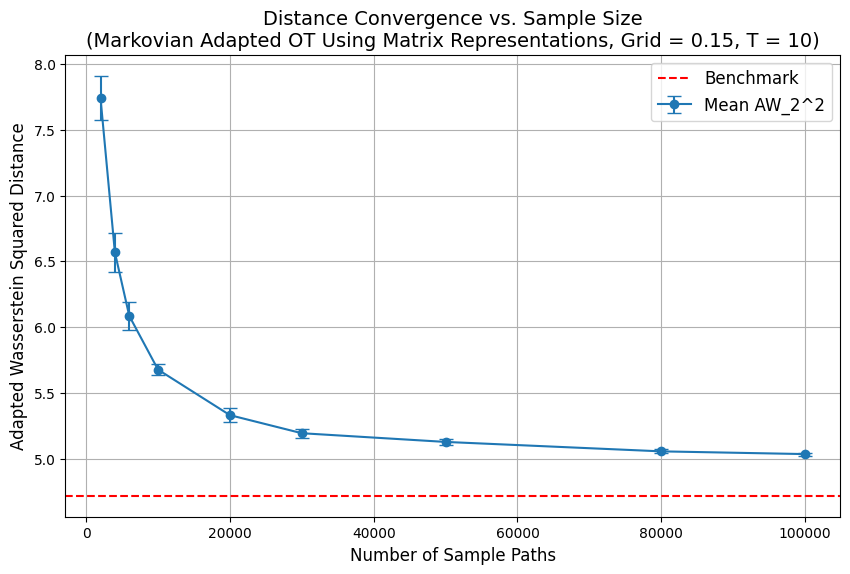

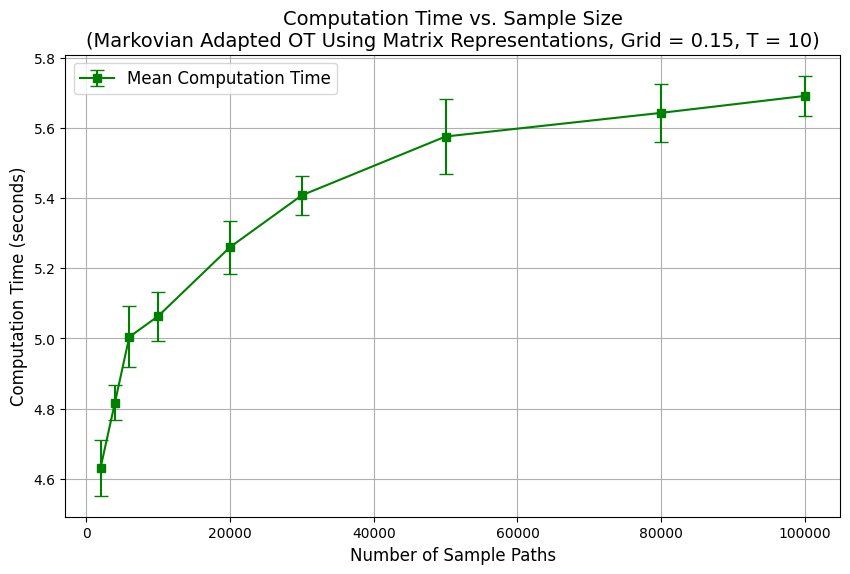

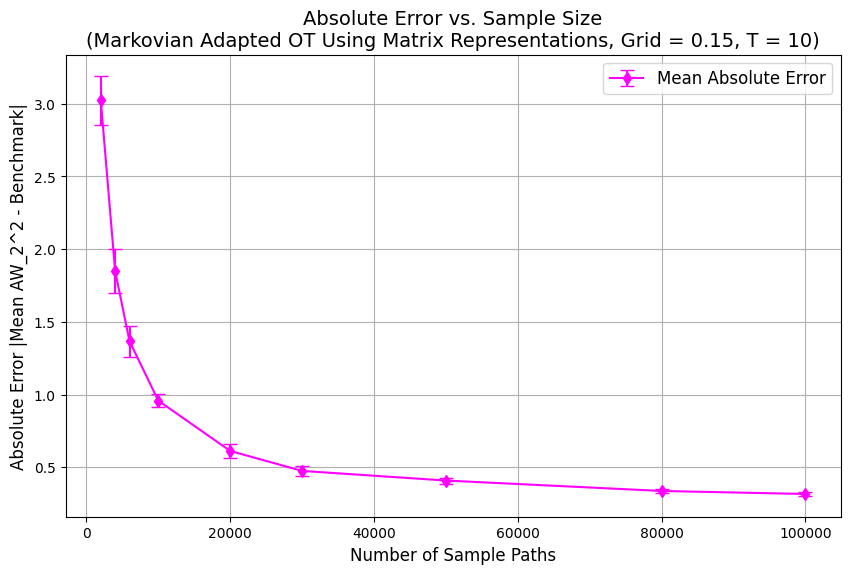

In [14]:

print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark_val = aggregated[sample_list[0]]["benchmark"]

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark_val, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Markovian Adapted OT Using Matrix Representations, Grid = 0.15, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Markovian Adapted OT Using Matrix Representations, Grid = 0.15, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Markovian Adapted OT Using Matrix Representations, Grid = 0.15, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()